<a href="https://colab.research.google.com/github/federicocampo/CMEPDA-Project/blob/main/WaveletDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into our repository to import all the needed functions.

In [1]:
!git clone https://github.com/federicocampo/CMEPDA-Project.git

Cloning into 'CMEPDA-Project'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 229 (delta 89), reused 50 (delta 21), pack-reused 0
Receiving objects: 100% (229/229), 3.47 MiB | 3.32 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [2]:
%cd /content/CMEPDA-Project/

/content/CMEPDA-Project


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [111]:
import os
from PIL import Image
import pywt
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import glob
import multiprocessing as mp

from keras.layers import BatchNormalization, Dense, Flatten, Activation, Dropout, Input
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

from sklearn.model_selection import KFold

from waveletconverter import dwtcoefftoarray

import logging

#Setting a logger and a logging level
logger = logging.getLogger('Mylogger')
logger.setLevel(logging.DEBUG)
#Setting an handler to send logging output
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
#Set the format of every log message printing the name of logger, logging level and the message.
formatter = logging.Formatter('%(name)s (%(levelname)s): %(message)s')
ch.setFormatter(formatter)
#Add the specified handler to this logger.
logger.addHandler(ch)

In [5]:
PATH = '/content/gdrive/My Drive/IMAGES/Mammography_micro'

def read_img(image_path):
  ''' Takes as input the path to the image folder and 
      returns the numpy array of images and label found in that folder
  '''

  # Creating a list of all image names found in image_path
  imagefilename = glob.glob(os.path.join(image_path, '*.pgm'))

  # Defining 4 sub-processes and apply imread to all the images found previously
  # (imread reads images in pgm format)
  pool = mp.Pool(processes=4)
  results = pool.map_async(Image.open, imagefilename)

  # Get the list of images and convert to numpy array
  images = results.get()

  logger.info(f'Num images found in {image_path}: {len(images)}')

  # Create a list of corrisponding labels and conver it to numpy array
  label = os.path.basename(image_path)
  y = [int(label)] * len(images)
  y_np = np.array(y)

  return images, y_np


# Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, 'Train/0')
# Create the test images and labels array with read_img function
images0_train, y0_train = read_img(image_path)

# Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, 'Train/1')
# Create the test images and labels array with read_img function
images1_train, y1_train = read_img(image_path)

# Create an array with both normal and microcalcifications containing images and labels
images_train = images0_train + images1_train
y_train = np.concatenate((y0_train, y1_train))

# Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, 'Test/0')
# Create the test images and labels array with read_img function
images0_test, y0_test = read_img(image_path)

# Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, 'Test/1')
# Create the test images and labels array with read_img function
images1_test, y1_test = read_img(image_path)

# Create an array with both normal and microcalcifications containing images and labels
images_test = images0_test + images1_test
y_test = np.concatenate((y0_test, y1_test))

images_tot = images_test + images_train
labels = np.concatenate((y_test, y_train))

Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Test/1: 196


In [91]:
wavelet = 'db5'
level = 4
denoise = 'no'

coefficients = []

for i, image in enumerate(images_tot):
  array = dwtcoefftoarray(images_tot[i], wavelet, level, denoise)
  coefficients.append(array)

coefficients = np.array(coefficients)

print(coefficients.shape)

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(797, 6042)


In [127]:
def make_model():
  model = Sequential([
                      Input(shape=(6042)),

                      Dense(50, activation='relu'),
                      Dense(25, activation='relu'),
                      Dense(25, activation='relu'),
                      Dense(50, activation='relu'),

                      Dense(1, activation='sigmoid')
  ])
  return model

In [21]:
#Set a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [128]:
''' Define the model and compile it
'''
model = make_model()
model.compile(optimizer = Adam(lr = 0.001), metrics = 'accuracy', loss='binary_crossentropy')

In [129]:
''' Training the model using x_train and y_train images and labels and doing a validation split of 30%
'''

val_split = 0.3

history = model.fit(coefficients, labels, 
                    validation_split=val_split, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

Epoch 1/100
19/19 [==============================] - 1s 16ms/step - loss: 13.1067 - accuracy: 0.5291 - val_loss: 4.4080 - val_accuracy: 0.3125

Epoch 00001: val_accuracy did not improve from 0.84167
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 3.6288 - accuracy: 0.4736 - val_loss: 2.8714 - val_accuracy: 0.3625

Epoch 00002: val_accuracy did not improve from 0.84167
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 1.2980 - accuracy: 0.6288 - val_loss: 3.8242 - val_accuracy: 0.2583

Epoch 00003: val_accuracy did not improve from 0.84167
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.7786 - accuracy: 0.6927 - val_loss: 0.7183 - val_accuracy: 0.7083

Epoch 00004: val_accuracy did not improve from 0.84167
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 1.6032 - accuracy: 0.6070 - val_loss: 3.0617 - val_accuracy: 0.3208

Epoch 00005: val_accuracy did not improve from 0.84167
Epoch 6/100
1

Text(0.5, 1.0, 'Accuracy and val_accuracy')

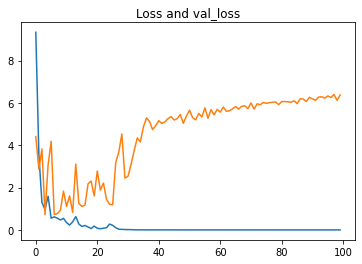

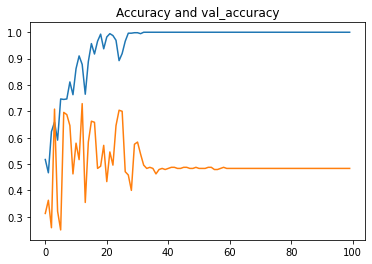

In [130]:
''' Visualize loss, val_loss, accuracy and val_accuracy obtanined during the train
''' 
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and val_accuracy')

In folder 1: loss of 3.2009 - accuracy of 0.6125
In folder 2: loss of 1.7804 - accuracy of 0.6500
In folder 3: loss of 1.4525 - accuracy of 0.5750
In folder 4: loss of 1.4413 - accuracy of 0.6500
In folder 5: loss of 1.0565 - accuracy of 0.5875
In folder 6: loss of 2.2118 - accuracy of 0.5750
In folder 7: loss of 2.3715 - accuracy of 0.5500
In folder 8: loss of 0.7715 - accuracy of 0.7089
In folder 9: loss of 1.2440 - accuracy of 0.6582
In folder 10: loss of 1.1315 - accuracy of 0.6456
Average scores for all folds:
-- Accuracy: 0.6212658166885376 (+- 0.04675241682291234)
-- Loss: 1.6661925613880157 +/- 1.2146691381931305


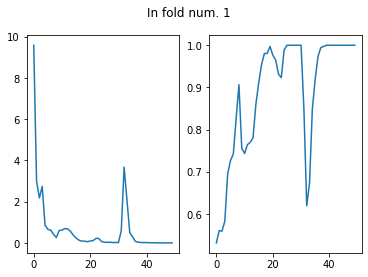

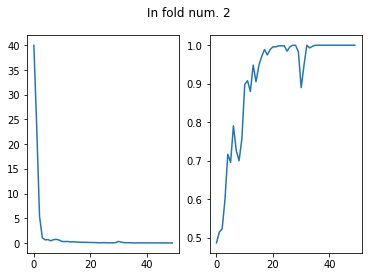

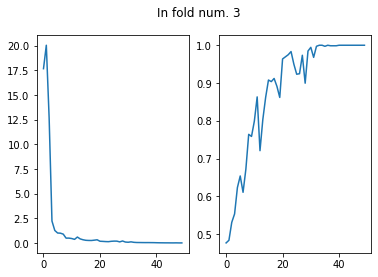

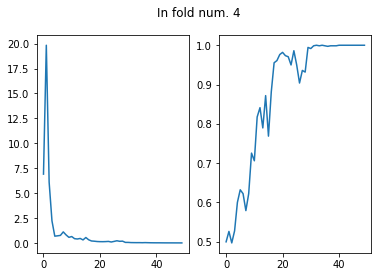

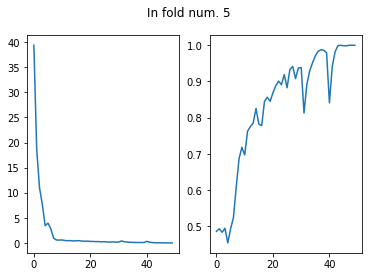

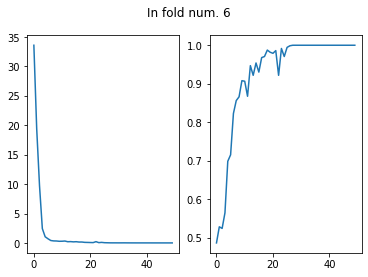

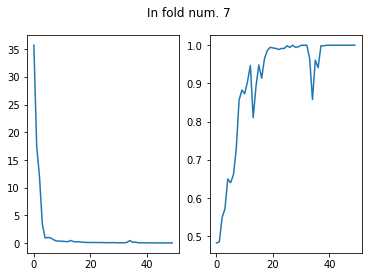

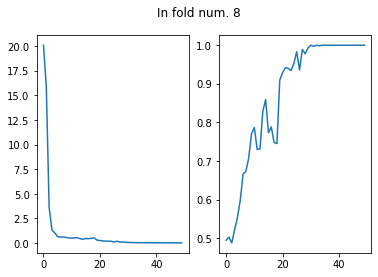

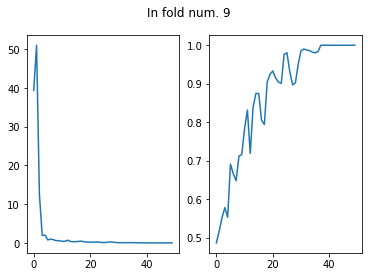

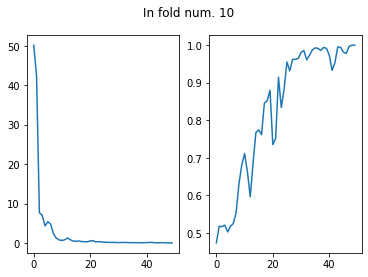

In [131]:
# Define per-fold accuracy and loss arrays
acc_per_fold = []
loss_per_fold = []

# Define the number of folds to split dataset on
num_folds = 10
# Defining the function KFold useful to split the dataset
kfold = KFold(n_splits = num_folds, shuffle=True)

batch_size = 32
num_epochs = 50

fold_num = 1

# Define the model and compile
model = make_model()
model.compile(optimizer=Adam(lr = 0.001), metrics = 'accuracy', loss='binary_crossentropy')
# Saving the weights before training as reset before each training
model.save_weights('reset_model.h5')

for train, test in kfold.split(coefficients, labels):
  ''' Training the model and test it for every fold created 
      from the total original dataset
  '''
  # Reset the model loading weights of untrained model
  model.load_weights('reset_model.h5')
  # Fitting the model using every folder but one as training
  history = model.fit(
          coefficients[train], labels[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  # Evaluate the efficiency of the model
  scores = model.evaluate(coefficients[test], labels[test], verbose=0)
  #Printing the results of the training
  print('In folder {:d}: {} of {:.4f} - {} of {:.4f}'.format(fold_num,
                                                          model.metrics_names[0],scores[0],
                                                          model.metrics_names[1], scores[1] ))
  

  # Visualize loss and accuracy obtanined during the train for each fold  
  plt.figure(fold_num)
  plt.suptitle(f'In fold num. {fold_num}')
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])

  #Putting scores on to the corrisponding list to calculate the mean value ot them at the end
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_num += 1

#Computing and printing average scores
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#Calculare loss error as maximum value error
err_loss = (max(loss_per_fold)-min(loss_per_fold))/2
print(f'-- Loss: {np.mean(loss_per_fold)} +/- {err_loss}')